In [725]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors
from torch.utils.data import TensorDataset
from two_spirals_utils import spiral_dataset, SpiralClassifier
from utils.utils import get_grid_predictions, create_contour_plot

# Define FGSM and PGD attacks

In [726]:
def fgsm(
        model:    torch.nn.Module,
        x:        torch.Tensor,
        label:   int,
        eps:      float,
        targeted: bool = True,
        clip_min: None|float = None,
        clip_max: None|float = None
    ) -> torch.Tensor:
    """
    Internal functionality for all FGSM and PGD attacks.

    Parameters
    ----------
    model : torch.nn.Module
        A model trained on the dataset for which the adversarial sample is to
        be generated.
    x : torch.Tensor
        The data sample to be turned into an adversarial sample.
    label : int
        If `targeted == True` this is the index of the (incorrect) class that
        the adversarial sample should get classified to. If `targeted == False`,
        this is the index of the correct class of `x`.
    eps : float
        Defines how far `x` gets shifted in any dimension. Should be small.
    targeted : bool, optional
        Defines whether the attack should be targeted or not, by default True.
    clip_min : _type_, optional
        Lower clipping range (e.g. 0 for pixels in [0, 1]), by default None
    clip_max : _type_, optional
        Upper clipping range (e.g. 1 for pixels in [0, 1]), by default None

    Returns
    -------
    torch.Tensor
        The perturbed input (adversarial example).
    """
    
    # Copy the input and remove connection to the compute graph
    input = x.clone().detach_()
    
    # Make sure we compute the loss gradient w.r.t. the input
    input.requires_grad_()

    # Run a forward pass of the model and compute the loss
    model.zero_grad()
    logits = model(input)
    target = torch.LongTensor([label])
    loss   = nn.CrossEntropyLoss()(logits, target)

    # Run backprop to get gradient w.r.t. the input we wish to modify
    loss.backward()
    
    # Perform either targeted or untargeted attack
    if targeted:
        x_adv = input - eps * input.grad.sign()
    else:
        x_adv = input + eps * input.grad.sign()
    
    # Optionally, clip the output back to a data domain
    # (useful for images in [0, 1]^n domain)
    if clip_min is not None or clip_max is not None:
        x_adv.clamp_(min=clip_min, max=clip_max)
    
    return x_adv

In [727]:
def pgd(
        model:    torch.nn.Module,
        x:        torch.Tensor,
        label:    int,
        k:        int,
        eps:      float,
        eps_step: float,
        targeted: bool,
        clip_min: None|float = None,
        clip_max: None|float = None
    ) -> torch.Tensor:
    """
    Performs a Projected Gradient Descent (PGD) attack on the input x.

    PGD is an iterative adversarial attack that attempts to find an adversarial
    example within an eps-ball around the input.

    Parameters
    ----------
    model : torch.nn.Module
        The model to attack.
    x : torch.Tensor
        The input tensor to perturb.
    label : int
        If `targeted == True` this is the index of the (incorrect) class that
        the adversarial sample should get classified to. If `targeted == False`,
        this is the index of the correct class of `x`.
    k : int
        The number of PGD iterations.
    eps : float
        Defines how far `x` gets shifted in any dimension. Should be small.
    eps_step : float
        The step size for each iteration.
    targeted : bool
       Defines whether the attack should be targeted or not, by default True.
    clip_min : _type_, optional
        Lower clipping range (e.g. 0 for pixels in [0, 1]), by default None
    clip_max : _type_, optional
        Upper clipping range (e.g. 1 for pixels in [0, 1]), by default None

    Returns
    -------
    torch.Tensor
        The perturbed input (adversarial example).
    """
    x_min = x - eps
    x_max = x + eps
    
    # Randomise the starting point x
    x_adv = x + eps * (2 * torch.rand_like(x) - 1)

    # Clamp starting point back to valid range
    if clip_min is not None or clip_max is not None:
        x_adv.clamp_(min=clip_min, max=clip_max)
    
    for _ in range(k):
        # FGSM step
        x_adv = fgsm(model, x_adv, label, eps_step, targeted)
        
        # Projection Step
        x_adv = torch.min(x_max, torch.max(x_min, x_adv))
        
    # Optionally, clip the output back to a data domain
    # (useful for images in [0, 1]^n domain)
    if clip_min is not None or clip_max is not None:
        x_adv.clamp_(min=clip_min, max=clip_max)

    return x_adv

# Load pre-trained classifier model

In [728]:
classifier = SpiralClassifier(2, 2, n_inner_layers=4, width=128)
classifier.load_state_dict(torch.load("../data/models/classifier_two_spirals.pt"))
classifier.eval();

# Visualise decision boundary of the trained classifier 

In [729]:
n_samples   = 20_000
noise       = 3
n_rotations = 1.2

# Generate spiral dataset
dataset = TensorDataset(*spiral_dataset(n_samples, noise, n_rotations))

In [730]:
# Number of adversarial samples (not yet implemeted for numbers > 1)
n_adv_samples = 1

# How far the adversarial attack may shift the sample along any dimension
eps = 1e-1

# Pick an index from the following list of indices that have been found to
# succeed with eps = 1e-1 adversarial samples
pick = 0
idx  = [9668, 9868, 9978, 11906, 12396, 12456, 12555, 12894, 16094, 16147, 16182, 19878][pick]

# Or pick an index at random
# idx = int(torch.randint(n_samples, (n_adv_samples,)).item())

x = dataset.tensors[0][[idx]]
y = dataset.tensors[1][[idx]].item()

In [731]:
# Generate adversarial sample
x_adv = fgsm(classifier, x=x, label=y, eps=1e-1, targeted=False).detach().numpy()

In [732]:
with torch.no_grad():
    pred = classifier(torch.from_numpy(x_adv))
    pred = pred.argmax(axis=1).item()

print(f"Model classifies adversarial attack on sample {idx} as class {pred}.")
print(f"Correct class is {y}.")
print(f"Adversarial attack was {'SUCCESSFUL' if pred != y else 'UNSUCCESSFUL'}.")

Model classifies adversarial attack on sample 9668 as class 1.
Correct class is 0.
Adversarial attack was SUCCESSFUL.


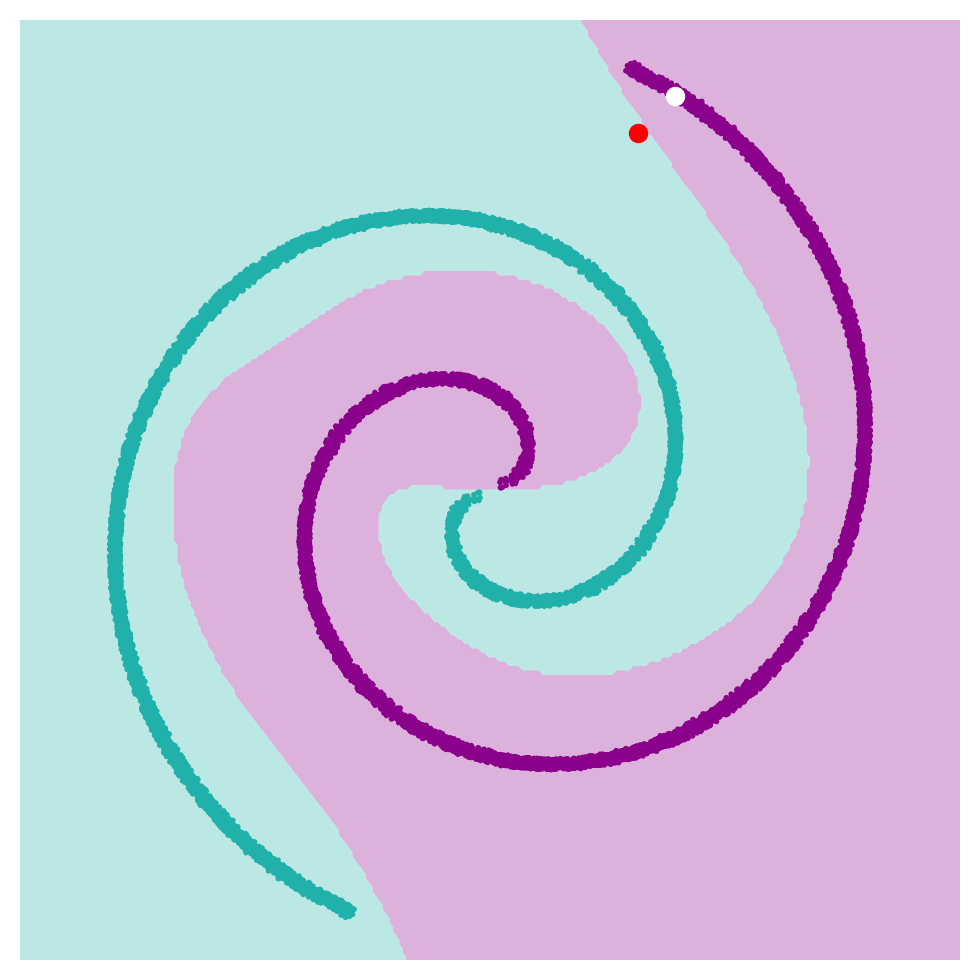

In [733]:
xs, ys, grid_preds = get_grid_predictions(classifier)
colormap = colors.ListedColormap(["darkmagenta", "lightseagreen"])
create_contour_plot(xs, ys, grid_preds, dataset=dataset, colormap=colormap)

plt.scatter(*x.T, c="white")
plt.scatter(*x_adv.T, c="red");